# NOTES

1. Adding the noise class seems to make a significant bump in accuracy
2. This model performs as well as the O'Shea paper and trains faster.

## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This is a [fork](https://github.com/mas-dse-greina/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb) of O'Shea, Corgan, and Clancy's Python Notebook.

More information on this classification method can be found at
https://arxiv.org/abs/1602.04105

More information on the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Please cite derivative works

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

To run this example, you will need to download or generate the RML2016.10a dataset (https://radioml.com/datasets/)
You will also need Keras installed with either the Theano or Tensor Flow backend working.

Have fun!

In [1]:
filepath = 'convmodrecnets_CNN2_Tony6'

In [2]:
# Standard python imports
# Nothing to see here. Move along.
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, sys
%matplotlib inline

## Keras
[Keras](https://keras.io/) is a python abstraction which allows you to define a neural network and have it automatically coded for deep learning libraries (currently DeepLearning4j, TensorFlow, and Theano). You just tell Keras how many layers are in the network model and define what those layers look like. Keras handles converting it into something that TensorFlow and Theano can use. So it's great for rapid development experimentation with neural networks. You can quickly build things and quickly tweak neural networks.

In [3]:
# Keras imports

# Keras defaults to using TensorFlow.  Nevertheless, we can force it
#    to use whichever deep learning library we wish by specifying
#    the OS variable KERAS_BACKEND.
#os.environ["KERAS_BACKEND"] = "theano"
# These THEANO_FLAGS force the use of the GPU. So remove them if you don't have a GPU.
# The code will run several orders of magnitude faster with GPU support.
# Nevertheless, the results are the same regardless of GPU or CPU processing.
# It just depends on how much time you are willing to wait for results.
# Without GPU support, trainining this neural network could take > 5 hours.
# With GPU support, training is reduced to < 30 minutes.
#os.environ["THEANO_FLAGS"]  = "floatX=float32,device=gpu,nvcc.flags=-D_FORCE_INLINES"

#os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam

Using TensorFlow backend.


# Dataset setup

O'Shea, Corgan, and Clancy generated a simulated data set using [GNU Radio](http://gnuradio.org). It is saved as a Pickle file. That's just a binary file that can be read into Python (it is a dictionary, similar to a JSON file).

There are other data files that you can use to train and test the model at the [radioml.com](https://radioml.com/datasets/radioml-2016-10-dataset/) website.  The Python file to create the dataset is [here](https://github.com/radioML/dataset/blob/master/generate_RML2016.10a.py).

In [4]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
Xd = cPickle.load(open('../RML2016.10a_dict.dat','rb'))

## Pickle format

The data that was saved contained one large Python dictionary array. The dictionary keys were the combinations of [modulation](https://en.wikipedia.org/wiki/Phase-shift_keying) type and signal to noise (SNR) ratios that were simulated by GNU Radio to produce the data. There are 11 modulation schemes: 8 digital and 3 analog. Gaussian white noise was added to each signal proportional to the signal's power.

For example, a [BPSK modulated](https://en.wikipedia.org/wiki/Phase-shift_keying#Binary_phase-shift_keying_.28BPSK.29) signal was simulated with SNRs of -20 dB, -18 dB, -16 dB, up to 18 dB. For a SNR of 0, the BPSK signal would have the same total power as the gaussian noise. For SNRs less than 0, the BPSK signal would be swamped by the noise. In other words, it'd be impossible for a human to identify the modulation for those SNRs.

$$ \text{SNR in decibels} = 10 \times \log \left ( \frac{\text{signal power}}{\text{noise power}} \right ) $$

In [5]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [6]:
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


### Radio frequency (RF) signals

Once we've specified the dictionary key (e.g. ['QAM64', 4] for QAM64 modulation @ 4 dB SNR), then we'll be left with the following matrix.

In [7]:
np.shape(Xd['QAM64', 0])

(1000, 2, 128)

+ The second dimension represents the two components ([I & Q](https://youtu.be/h_7d-m1ehoY)) of the RF signal. 
+ The third dimension represents the 128 samples in time (1 MHz so 1 $\mu$s per index)
+ The first dimension represents the 1,000 sampled windows (each window has the 128 I & Q samples)

# Please help me correct this. I am not sure if I am calculating the raw signal correctly.

$$\text{Modulated Carrier RF} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

In [8]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 10e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

## Let's plot some of the raw data

So we'll just choose one 8PSK (with SNR @ 18 dB), one PAM4 (with SNR @ 6 dB), one BPSK (with SNR @ 0 dB), and one QAM64 (with SNR @ -12 dB).

Notice how the signal gets buried in the noise as the SNR decreases.

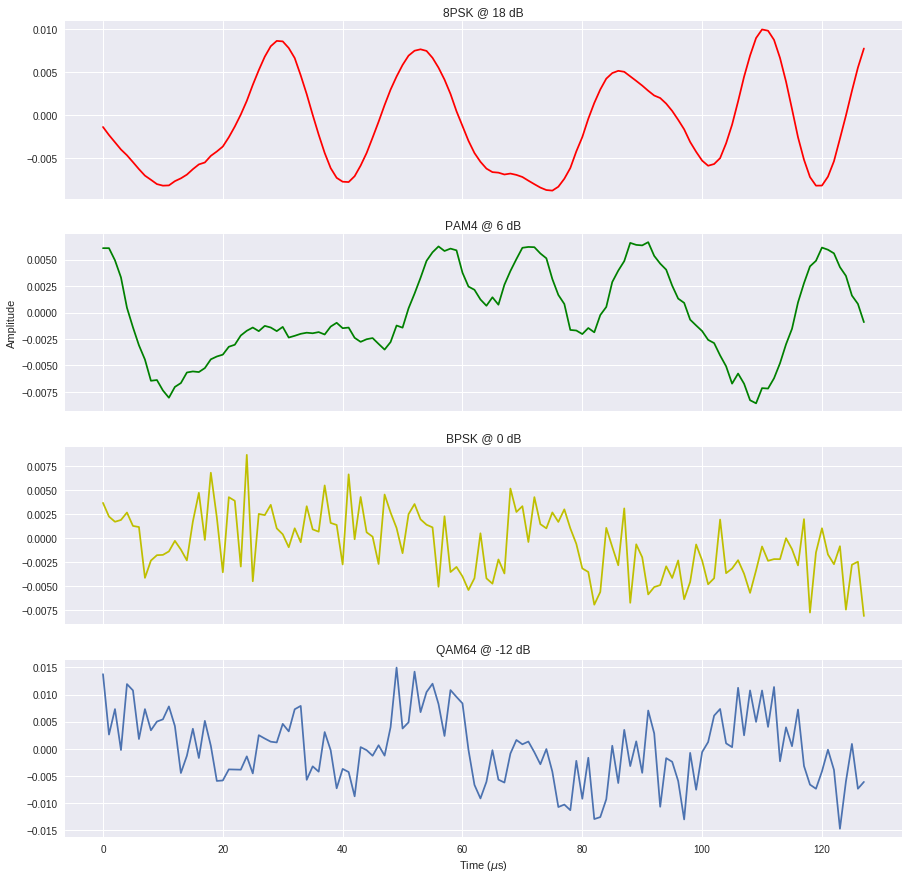

In [9]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

## Now we need to append all of the modulation, SNR, samples, channels, and time points into one big matrix to pass into our neural net.

So there will be 220,000 samples. Each sample is 2 x 128. The 2 are the I and Q channels. The 128 are the 128 time samples of the waveform (sampled at 1 MHz).

In [10]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [11]:
np.shape(X)

(220000, 2, 128)

## Add noise class to dataset

So let's just add 2 channels of random Gaussian noise to see if we can give the network an option to pick if it can't decide between the true modulations. This is basically an "I don't know" classification.

In [12]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples): 
    lbl.append(['Noise', snrs[i%len(snrs)]])
    
mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

### Now let's randomly partition the dataset into a training group and a test group.

The training group will be used to calculate the weights for the neural network. The test group will be used to evaluate (validate) how well those weights generalize to new data (i.e. how well our neural net should perform in the wild).

Our first step is to [One Hot Encode](https://en.wikipedia.org/wiki/One-hot). It sounds bad, but is a really simple procedure. Basically, the computer doesn't understand letters; it can only use numbers. So it has no idea what '8PSK' or 'WBFM' refers to and has no way to train a model to fit those labels. Now we could just assign a number to each modulation (e.g. 1 = '8PSK', 2 = 'AM-DSB', 3 = 'PAM4', etc). However, one-hot encoding makes it easier for us to calculate how close our neural network's output (i.e. the prediction) is to the true (expected) value.

To one-hot encode we simple declare a vector that is as large as the set of unique modulations. So if we have 11 modulations, then we declare a vector of size 1 x 11. The array is 0 everywhere except for the modulation being represented. For example,

+  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
+  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
+  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
  
So the left-most element codes '8PSK' and the right-most codes 'WBFM'. The positioning is arbitrary. It just has to be consistently applied to the dataset.

Once we've One Hot encoded, we'll be able to compare how close our neural network's output (i.e. the prediction) comes to the true modulation. This "closeness" measurement is typical calculated via (Shannon) cross-entropy. There's a great [video here](https://www.youtube.com/watch?v=tRsSi_sqXjI).

$$ \text{cross entropy} = - \sum_i{L_i \log{S_i}}$$

where 
+ $i$ goes from 1 to the number of modulations
+ $L_i$ is the one-hot label for that sample in that modulation
+ $S_i$ is the neural network's prediction for that sample in that modulation

For instance,  if our neural network predicts 3 classes with the following probabilities:

$$\begin{bmatrix}0.2\\0.7\\0.1 \end{bmatrix}$$

and the actual sample has the one-hot encoding of:

$$\begin{bmatrix}0\\1\\0\end{bmatrix}$$

Then our cross-entropy is:  
$$ - [ 0 \times \log(0.2) + 1 \times \log(0.7) + 0 \times \log(0.1) ] = \log(0.7) = 0.155$$

If the prediction is perfect, then the cross-entropy is $1 \times \log(1) = 0$

In [13]:
from sklearn.preprocessing import LabelBinarizer

lbl = np.array(lbl) # Convert from list to numpy array (for speed)

# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

## Split into a training and testing set

It's crucial that we split the data into at least 2 sets. One set (called the training set) will be used to train the neural network. That is, the weights of the neural network will be adjusted to make the best possible prediction of the training data. However, if we just stopped there, then we'd have a model that was good at predicting things it already knew the answers to. We want to ensure that the model can predict things it has never seen before. So we save some data (usually about 1/4 to 1/3) to test whether the trained neural network can be just as accurate on data it has never seen.

Most decent machine learning toolkits contain a method to randomly split your data into these two sets. We typically use the one from sklearn (train_test_split). However, we want to keep track of the indices so that we can also get the SNRs at the end. So we'll just use a random array to split the two groups.

In [14]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)  

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [15]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


In [16]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print X_train.shape, in_shp
classes = mods

(168000, 2, 128) [2, 128]


# Build the NN Model

In [17]:
from keras.layers import LSTM

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 3 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers

model.add(Reshape(in_shp+[1], input_shape=in_shp))  

# #model.add(ZeroPadding2D((0, 2)))  # Add 2 columns of zeros to each side
model.add(Convolution2D(16, (1, 16), padding='valid', strides=(1,2), activation="relu", name="conv1", kernel_initializer='glorot_uniform'))

#model.add(MaxPooling2D(pool_size=(1, 2)))

# #model.add(ZeroPadding2D((0, 2))) # Add 2 columns of zeros to each side
model.add(Convolution2D(32, (2, 8), padding="valid", strides=(1,2),activation="relu", name="conv2", kernel_initializer='glorot_uniform'))

#model.add(MaxPooling2D(pool_size=(1, 2)))

# #model.add(ZeroPadding2D((0, 2))) # Add 2 columns of zeros to each side
model.add(Convolution2D(64, (1, 4), padding="valid", activation="relu", name="conv3", kernel_initializer='glorot_uniform'))

#model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, kernel_initializer="he_normal", activation="relu", name="dense1"))

model.add(Dropout(dr))

model.add(Dense(256, kernel_initializer="he_normal", activation="relu", name="dense2"))

model.add(Dropout(dr))

model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense3" ))

model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 57, 16)         272       
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 25, 32)         8224      
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 22, 64)         8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               721408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
__________

In [18]:
# Set up some params 
nb_epoch = 150     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [19]:
# Check if there is a previous weights file and load it if it exists.
# This will allows us to resume from where we left off.
# import os

# if (os.path.exists(filepath + '.wts.h5')):
#     model.load_weights(filepath + '.wts.h5')

In [20]:
# perform training ...
#   - call the main training loop in keras for our network+dataset

modelWeightsFile = filepath + '.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Train on 168000 samples, validate on 72000 samples
Epoch 1/150
Epoch 00000: val_loss improved from inf to 1.77712, saving model to convmodrecnets_CNN2_Tony4copy.wts.h5
6s - loss: 2.0944 - acc: 0.2156 - val_loss: 1.7771 - val_acc: 0.3267
Epoch 2/150
Epoch 00001: val_loss improved from 1.77712 to 1.67846, saving model to convmodrecnets_CNN2_Tony4copy.wts.h5
5s - loss: 1.7292 - acc: 0.3449 - val_loss: 1.6785 - val_acc: 0.3568
Epoch 3/150
Epoch 00002: val_loss improved from 1.67846 to 1.51261, saving model to convmodrecnets_CNN2_Tony4copy.wts.h5
5s - loss: 1.5824 - acc: 0.3968 - val_loss: 1.5126 - val_acc: 0.4191
Epoch 4/150
Epoch 00003: val_loss improved from 1.51261 to 1.44255, saving model to convmodrecnets_CNN2_Tony4copy.wts.h5
5s - loss: 1.5003 - acc: 0.4239 - val_loss: 1.4426 - val_acc: 0.4399
Epoch 5/150
Epoch 00004: val_loss improved from 1.44255 to 1.42055, saving model to convmodrecnets_CNN2_Tony4copy.wts.h5
5s - loss: 1.4591 - acc: 0.4364 - val_loss: 1.4205 - val_acc: 0.4436
Epo

# Evaluate and Plot Model Performance

In [21]:
from sklearn.metrics import classification_report
y_predict = model.predict_classes(X_test)
print()
print()
print(classification_report(np.argmax(Y_test, axis=1), y_predict))

71296/72000 [============================>.] - ETA: 0s 

## Loss curves

Loss curves show us how well the training went. They also allow us to detect over-training of the model. If the model is over-trained, then it might not generalize well. Often, in an over-trained model, the training loss (error) will continually decrease while the validation (test error) will decrease and then begin to increase again with successive training epochs.

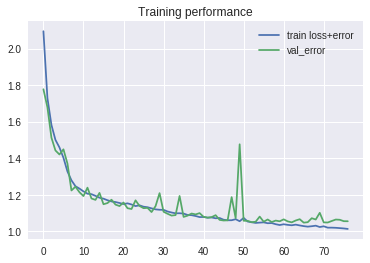

In [22]:
# Show loss curves 
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

# Confusion Matrix

A confusion matrix is a great way to see where the model (neural network) had trouble. It plots the number of times the model predicted a modulation versus the actual modulation (predicted versus true).

In [23]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

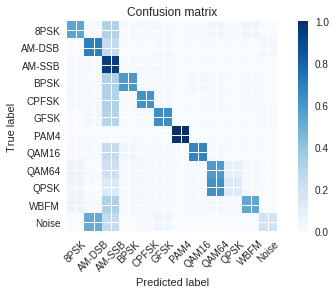

In [24]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



## In general, the model had a difficult time predicting AM-DSB modulation. Otherwise, it did a decent job at predicting the correct modulation.

Overall Accuracy for SNR -20: 0.165409332216
Overall Accuracy for SNR -18: 0.173082248685
Overall Accuracy for SNR -16: 0.174364580486
Overall Accuracy for SNR -14: 0.180187637969
Overall Accuracy for SNR -12: 0.210021905805
Overall Accuracy for SNR -10: 0.266956049919
Overall Accuracy for SNR -8: 0.389030251626
Overall Accuracy for SNR -6: 0.529527008116
Overall Accuracy for SNR -4: 0.656991348032
Overall Accuracy for SNR -2: 0.740209597352
Overall Accuracy for SNR 0: 0.79843444227
Overall Accuracy for SNR 2: 0.830575035063
Overall Accuracy for SNR 4: 0.844246308164
Overall Accuracy for SNR 6: 0.844837106571
Overall Accuracy for SNR 8: 0.85462678222
Overall Accuracy for SNR 10: 0.850138504155
Overall Accuracy for SNR 12: 0.85369955157
Overall Accuracy for SNR 14: 0.858227848101
Overall Accuracy for SNR 16: 0.838531603643
Overall Accuracy for SNR 18: 0.850167410714


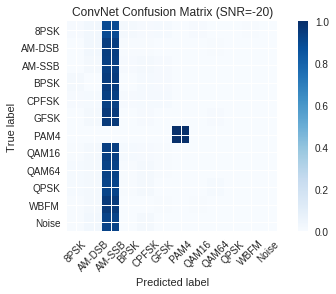

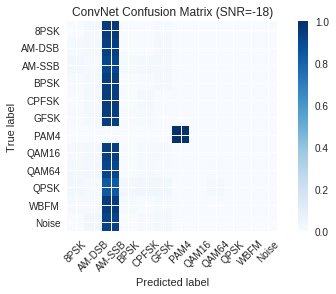

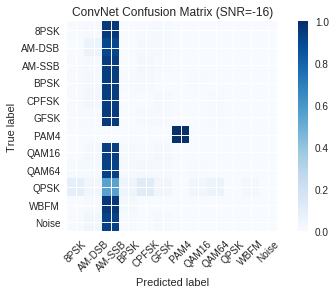

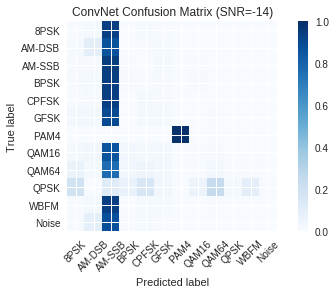

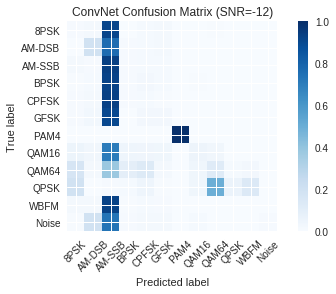

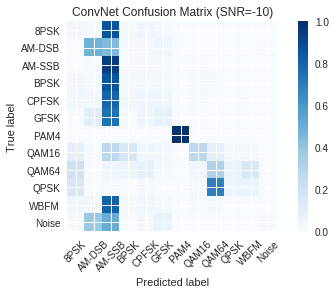

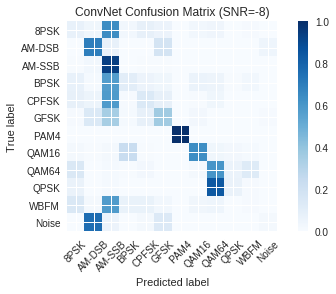

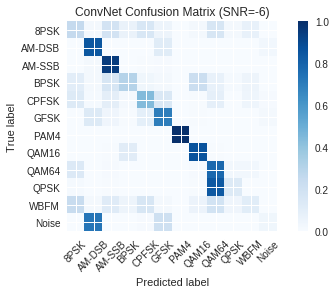

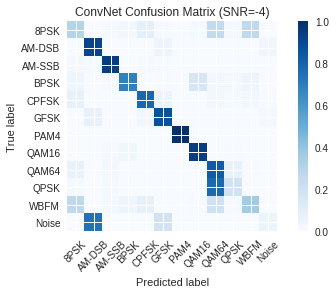

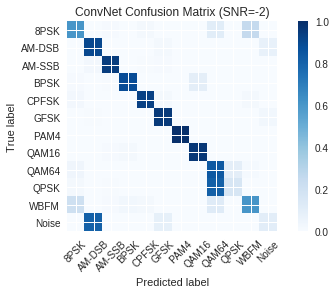

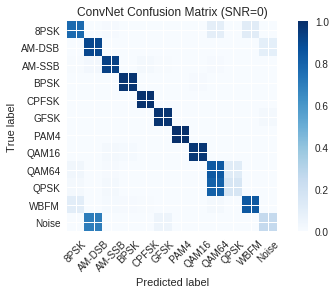

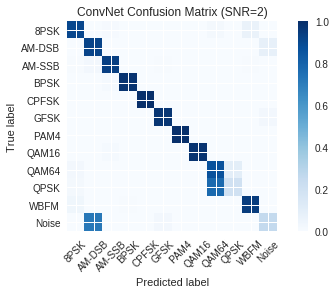

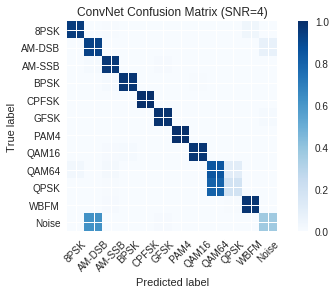

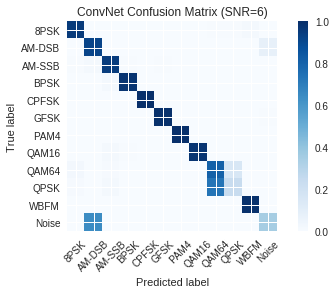

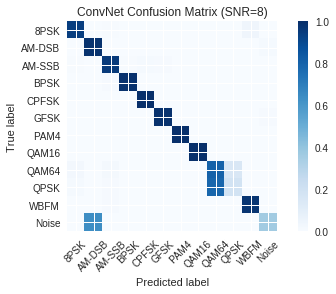

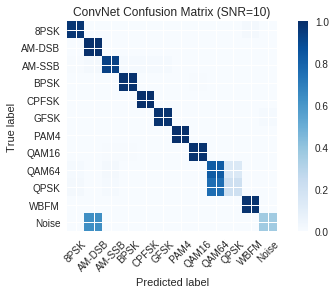

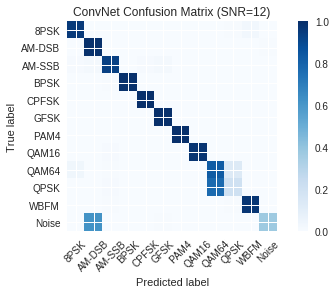

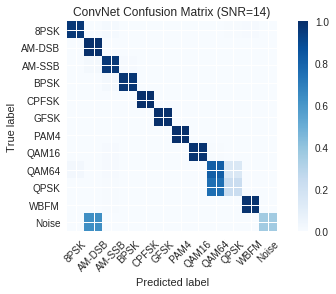

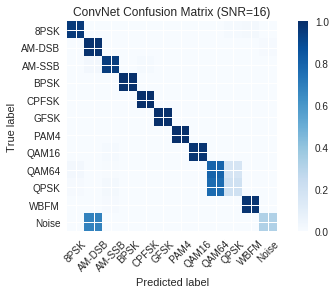

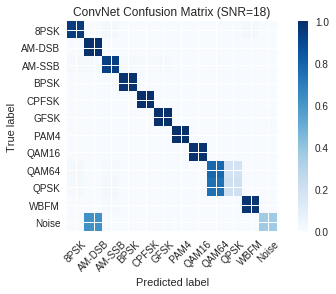

In [25]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [26]:
# Save results to a pickle file for plotting later
print acc
fd = open(filepath + '.results.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.79843444227005866, 16: 0.83853160364338941, 2: 0.83057503506311359, 4: 0.84424630816383395, 6: 0.84483710657095523, 8: 0.8546267822197372, 12: 0.85369955156950672, 10: 0.85013850415512471, -20: 0.1654093322157027, 18: 0.8501674107142857, -18: 0.17308224868457492, -16: 0.17436458048647172, -14: 0.18018763796909493, -12: 0.21002190580503832, 14: 0.85822784810126584, -10: 0.26695604991861094, -8: 0.38903025162567145, -6: 0.52952700811642872, -4: 0.65699134803237513, -2: 0.74020959735245451}


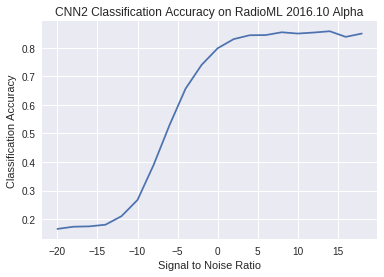

In [27]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");